# Implementing Logistic Regression, Step by Step

You've see the theory part of Logistic Regression, now let's see how to implement it.

In [1]:
# import necessary modules
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit as sigmoid

from evaluation import test
from utils import load_data, predict_image, scatter_plot, contour_plot
from utils import plot_boundary, load_cat_dataset, load_iris_2D
from utils import plot_costs

from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder

from lr import LogisticRegression

In this tutorial, you will learn 
- What are the training process of logistic regression.
- How to predict new data using the model we have trained.
- How to use logistic regression to predict multiclass dataset.
- What is stochastic gradient descent and how to implement it in logistic regression.
- How to calculate cost and plot cost change
- How to implement l2 (Ridge) regularization on gradient descent.

First let's an example how logistic regression works

In [2]:
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
y = np.array([0, 0, 1, 1])
clf = linear_model.LogisticRegression(solver='lbfgs')
clf.fit(X, y)
clf.predict(X)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

array([0, 0, 1, 1])

## Training

Given `X`, we need to learn weight so that our model can predict results using

```python
sigmoid(np.dot(X, coef_) + intercept_)
```

In [3]:
m, n_features = X.shape
coef_ = np.zeros(shape=(1, n_features))
intercept_ = np.zeros(shape=(1,))

Every iteration we update the weights by the vectorized equation given by the [theory](https://nickyfoto.github.io/blog/entries/logistic-regression) part.

In [4]:
y.shape = (m, 1)
max_iter = 100
learning_rate = 1e-2
for step in range(max_iter):  
    preds = sigmoid(np.dot(X, coef_.T) + intercept_)
    error = preds - y
    gradient = np.dot(X.T, error) 
    coef_ -= learning_rate * gradient.T / m
    intercept_ -= learning_rate * error.sum() / m
coef_, intercept_

(array([[0.51392593, 0.35277722]]), array([-4.99600361e-18]))

## Predicting

After finishing the learning, we can use the weight and the sigmoid function to predict new data. If the output value is greater than 0.5, we output 1, otherwise we output 0.

In [5]:
sigmoid(np.dot(X, coef_.T) + intercept_)
sigmoid(np.dot(X, coef_.T) + intercept_).round().astype(np.int).ravel()

array([[0.29594077],
       [0.20090799],
       [0.70405923],
       [0.79909201]])

array([0, 0, 1, 1])

You may notice that for now our algorithm only support binary classification with value `[0,1]`. What if we have other labels values such as `[1,2]` or even text ones? [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) comes to rescue.

## Predict Multiclass Dataset

`LabelEncoder` removes the restriction our label value, but our model is still a binary classifier. We need to make some change to our algorithm so that it can predict more than two classes.

In [6]:
X = np.array([[-1, -1], 
              [-2, -1], 
              [1, 1], 
              [2, 1],
              [5, 6],
              [7, 8]])
y = np.array([1, 1, 2, 2, 3, 3])

To predict the above dataset. The first thing we need to do is to change the shape of `coef_` and `intercept_` so that when we use 

```python
np.dot(X, coef_.T) + intercept_
```

to predict the label, it can output a row vector of the probability that item belongs to each of the three class.

In [7]:
n_classes = len(np.unique(y))
m, n_features = X.shape
coef_ = np.zeros(shape=(n_classes, n_features))
intercept_ = np.zeros(shape=(n_classes,))

There are two methods to predict multiclass labels, we look at one versus rest first. On `ovr` setting, we format our multiclass task into `k` binary classification problem, where `k` refers to the number of classes in the training set. In the above example, we have `k = 3`. For every binary classification, we need to change `y` into

```python
y_i = np.apply_along_axis(lambda x: np.where(x == i, 1, 0), axis=0, arr=y)
```

Then we training and save the learning weights into `coef_` and `intercept_`.

Then we training and save the learning weights into `coef_` and `intercept_`.

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)
classes_ = le.classes_
k = len(classes_)
max_iter = 1000
for i in range(k):
    y_i = np.apply_along_axis(lambda x: np.where(x == i, 1, 0), axis=0, arr=y)
    for step in range(max_iter):  
        preds = sigmoid(np.dot(X, coef_[i].T) + intercept_[i])
        error = preds - y_i
        gradient = np.dot(X.T, error) 
        coef_[i] -= learning_rate * gradient.T / m
        intercept_[i] -= learning_rate * error.sum() / m
coef_
intercept_

array([[-1.32043175, -1.03902171],
       [ 0.95449385, -1.02779511],
       [ 0.03911706,  0.67693788]])

array([-0.01246303, -0.28576712, -1.72829777])

As before we use our sigmoid function to predict new data. But instead of outputing a single value to threshold at 0.5, it outputs the probability of a example belongs to each class, we classify the class with the highest value.

In [9]:
scores = sigmoid(np.dot(X, coef_.T) + intercept_)
scores
classes_[scores.argmax(axis=1)]

array([[9.12694714e-01, 4.47082450e-01, 7.98525066e-02],
       [9.75093928e-01, 2.37404969e-01, 7.70251656e-02],
       [8.53394251e-02, 4.11185102e-01, 2.66541155e-01],
       [2.43078387e-02, 6.44609029e-01, 2.74257909e-01],
       [2.62940044e-06, 1.57086393e-01, 9.26144159e-01],
       [2.34672728e-08, 1.38635322e-01, 9.81312291e-01]])

array([1, 1, 2, 2, 3, 3])

Wrap up all the above step in a `LogisticRegression` class, we can train and predict as follows.

In [10]:
X = np.array([[-1, -1], 
              [-2, -1], 
              [1, 1], 
              [2, 1],
              [5, 6],
              [7, 8]])
y = np.array([1, 1, 2, 2, 3, 3])
clf = LogisticRegression()
clf.fit(X, y)
preds = clf.predict(X)
preds

LogisticRegression(c_lambda=0, fit_intercept=True, learning_rate=0.5,
                   max_iter=2000, penalty=None, print_cost=False, sgd=False)

array([1, 1, 2, 2, 3, 3])

This finishes our first implementation of logistic regression. Note that our model learns weights in a iterative manner called gradient descent. For each epoch, we averge the gradient and update the weights once. Another alternative gradient descent method, you might have heard is called stochastic gradient descent, which update the weight on every training example. Let's see how to implement it next.

---

## Stochastic Gradient Descent Logistic Regression

Previous we use `X` to calculate the predictions for the whole training set.

```python
preds = sigmoid(np.dot(X, self.coef_.T) + self.intercept_)
```

Now for every training example `x`, we predict it as:

```python
pred = sigmoid(np.dot(x, self.coef_.T) + self.intercept_)
```

Then update `coef_` and `intercept_`

In [11]:
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
y = np.array([0, 0, 1, 1])
m, n_features = X.shape
coef_ = np.zeros(shape=(1, n_features))
intercept_ = np.zeros(shape=(1,))
y.shape = (m, 1)
max_iter = 100
learning_rate = 1e-2
for step in range(max_iter):
    for idx, x in enumerate(X):
        pred = sigmoid(np.dot(x, coef_.T) + intercept_)
        error = pred - y[idx]
        gradient = x * error
        coef_ -= learning_rate * gradient.T
        intercept_ -= learning_rate * error
coef_, intercept_

(array([[1.09231379, 0.78699242]]), array([-0.00190078]))

The prediction part remains unchanged

In [12]:
sigmoid(np.dot(X, coef_.T) + intercept_)
sigmoid(np.dot(X, coef_.T) + intercept_).round().astype(np.int).ravel()

array([[0.1322503 ],
       [0.04863655],
       [0.86731283],
       [0.95118724]])

array([0, 0, 1, 1])

Wrap all the details in class we got

In [13]:
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
y = np.array([0, 0, 1, 1])
clf = LogisticRegression(sgd = True, max_iter=100, learning_rate = 1e-2)
clf.fit(X, y)
clf.predict(X)

LogisticRegression(c_lambda=0, fit_intercept=True, learning_rate=0.01,
                   max_iter=100, penalty=None, print_cost=False, sgd=True)

array([0, 0, 1, 1])

## Loss function

Note that we use gradient descent to minimize the negative log likelihood cost function. But how do we know our model is doing thr right job? It turns out that we calculate the cost in every iteration 

```python
ll = - (np.dot(target.T,  np.log(preds)) + np.dot((1 - target).T, np.log(1 - preds))) / m
```

and plot its change for reference.

LogisticRegression(c_lambda=0, fit_intercept=True, learning_rate=0.01,
                   max_iter=1000, penalty=None, print_cost=False, sgd=False)

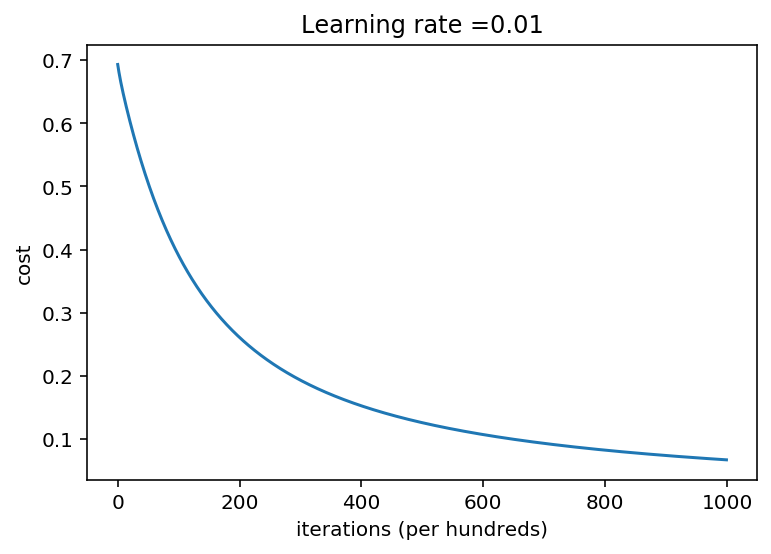

In [14]:
X, y = datasets.load_iris(return_X_y=True)
X = X[:100]
y = y[:100]
clf = LogisticRegression(print_cost = False, max_iter=1000, learning_rate = 1e-2)
clf.fit(X, y)
plot_costs(clf)

LogisticRegression(c_lambda=0, fit_intercept=True, learning_rate=0.0001,
                   max_iter=3000, penalty=None, print_cost=False, sgd=True)

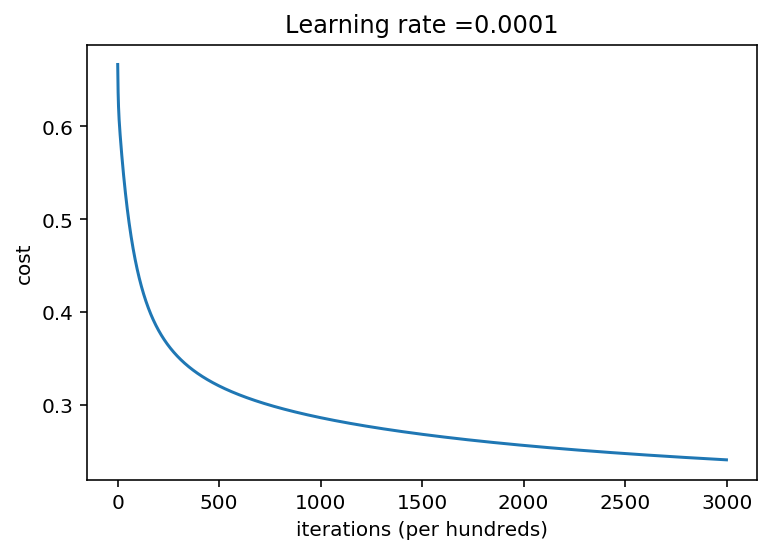

In [15]:
X, y = datasets.load_iris(return_X_y=True)
clf = LogisticRegression(print_cost = False, max_iter=3e3, learning_rate=1e-4, sgd=True)
clf.fit(X, y)
plot_costs(clf)

## Regularization

To tackle overfitting problem, we add l2 regularization term.

```python
coef_ -= learning_rate * (gradient.T + c_lambda * coef_) / m
```

In [17]:
X = np.array([[-1, -1], 
              [-2, -1], 
              [1, 1], 
              [2, 1],
              [5, 6],
              [7, 8]])
y = np.array([1, 1, 2, 2, 3, 3])
c_lambdas = np.logspace(-4, 4, 10)
scores = [LogisticRegression(penalty='l2', sgd=True, learning_rate=1e-3,
                             c_lambda=c_lambda, max_iter=1000).fit(X,y).score(X, y)
          for c_lambda in c_lambdas
         ]

In [18]:
print(scores)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.8333333333333334, 0.6666666666666666, 0.8333333333333334]
